In [15]:
# INPUTS

test_cfg = '/home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.43'

threshold = 1e-3 # used by spglib for identifying spacegroup of cfgs


## Degeneracy algorithm development

### Plan:

- Use 'POSCAR_orig' files to most closely mimic the proceedure originally performed by CASM for filtering out symmetrically equivalent structures
- Create parent of cfg by making all species Co or Mn
- Use spglib to get symm ops of parent
- One-at-a-time: Create random TM substitutions for cfg (on td or oh sites depending on if set A or B), apply all parent symm ops, if any converted cfg matches original symm_degeneracy += 1, move on to next random cfg
- Generating all permutations of a list of length 16 (for oh sites) is prohibitively slow, hence instead sample randomly by shuffling 100*combinations times and counting number of degenerate structures for each original cfg as a fraction of 100k attempts for each orig cfg (justified approach because we want to weight each config relative to each other in terms of number of symmetrically degenerate structures that exist for each cfg and were discounted by CASM)

### Dependencies:
- Python3
- ase
- spglib

### Key references:

- Section 2.1 of: https://iopscience.iop.org/article/10.1088/0953-8984/19/25/256201
- spglib python interface: https://atztogo.github.io/spglib/python-spglib.html#get-symmetry
- spglib paper: https://arxiv.org/pdf/1808.01590.pdf

### Key functions:

- `get_spglib_from_ase` and `get_ase_from_spglib` for converting between ase and spglib inputs for config
- `all_operations` --> to apply rotation, translation symmetry operations to config and to account for periodicity
- `plot_cell_custom_3D` --> visualising atomic structures
- `atom_nums_with_coords` to create np array for atom types and coords then use `compare_cfgs` to compare a config to a candidate symmetrically equivalent config

### Useful snippets:

#### Reading a VASP poscar with ase:
```
ase_cell = ase.io.read(poscar, format='vasp')
```

#### Using spglib to obtain symmetry operations of a structure:
```
symm_ops = spg.get_symmetry(spglib_cell, threshold)
# Combination of rotation and translation to give total symmetry operation
tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]
```

#### Checking for equivalence between a structure and that after applying all of its symmetry operations:
```
symm_op_count = len(symm_ops['rotations'])

same_cfg_count = 0
for op_num in range(symm_op_count):
    symm_cfg = all_operations(ase_cell, symm_ops, op_num)
    is_same_as_orig = compare_cfgs(ase_cell, symm_cfg)
    if not is_same_as_orig:
        print('Uh oh, strucuture is not the same as the original!')
    else: 
        same_cfg_count += 1
        
print('Number of symmetry operations: '+str(symm_op_count))
print('Number of same structures: '+str(same_cfg_count))
```

In [107]:
%matplotlib inline
import ase
import ase.io
import math
import matplotlib.pyplot as plt
from ase.visualize.plot import plot_atoms
from ase import Atoms
import numpy as np
from mpl_toolkits import mplot3d
from IPython.core.pylabtools import figsize
figsize(5, 5)
import os
import time
import re
import pandas as pd

try:
    import spglib as spg
except ImportError:
    from pyspglib import spglib as spg
    

In [150]:
# 1. Methods for converting between ase and spglib cell formats ----------------------------------------------

def get_spglib_from_ase(ase_cell):
    lattice = ase_cell.get_cell()
    positions = ase_cell.get_scaled_positions()
    numbers = ase_cell.get_atomic_numbers()
    spglib_cell = (lattice, positions, numbers)
    return spglib_cell
def get_ase_from_spglib(spglib_cell):
    ase_cell = Atoms(cell=spglib_cell[0], scaled_positions=spglib_cell[1], pbc=True)
    ase_cell.set_atomic_numbers(spglib_cell[2])
    return ase_cell


# 2. Methods for applying symmetry operations to ase atoms objects ----------------------------------------

# Rotate cell 
def rotate_cfg(ase_cell, rotate_symm_op):
    #rotated_cell = np.matmul(rotate_symm_op, ase_cell.get_cell())
    rotated_cell = np.matmul(ase_cell.get_cell(), rotate_symm_op) #test after reading spglib App. A, order doesn't matter here
    rotated = Atoms(cell=rotated_cell, scaled_positions=ase_cell.get_scaled_positions(), pbc=True)
    rotated.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return rotated
# Translate atoms
def translate_cfg(ase_cell, translate_symm_op):
    # Note: spglib uses fractional coords!
    positions = ase_cell.get_scaled_positions()
    translated_positions = positions + translate_symm_op
    translated = Atoms(cell=ase_cell.get_cell(), scaled_positions=translated_positions, pbc=True)
    translated.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return translated
# A test function to account for periodicity in final translated and rotated structure
def abs_latt_vecs(ase_cell):
    lattvec = ase_cell.get_cell()
    lattvec_abs = np.absolute(lattvec)
    ase_cell_abs = Atoms(cell=lattvec_abs, scaled_positions=ase_cell.get_scaled_positions(), pbc=True)
    ase_cell_abs.set_atomic_numbers(ase_cell.get_atomic_numbers())
    return ase_cell_abs
def all_operations(ase_cell, symm_ops, op_num):
    rotated_cell = rotate_cfg(ase_cell, symm_ops['rotations'][op_num])
    rotated_and_translated = translate_cfg(rotated_cell, symm_ops['translations'][op_num])
    rotated_and_translated_abs_cell = abs_latt_vecs(rotated_and_translated)
    return rotated_and_translated_abs_cell

    
# 3. Methods for creating plots to visualise atomic arrangements ---------------------------------------------

# Use ase to create plot of cell structure (not very nice in 3D!)
# Also appears to always set cell vectors to positive values, not useful for comparing after symm ops
def plot_cell_ase(cell, title):
    fig, ax = plt.subplots()
    plt.title(title)
    plot_atoms(cell, ax, radii=0.3, rotation=('0x,0y,0z'))
    
# NOTE: Different colours for each species only works for up to ternary structures in function below   
def plot_cell_custom_3D(ase_cell, title):
    figsize(5, 5)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)

    lattice = ase_cell.get_cell()
    positions = ase_cell.get_positions()
    numbers = ase_cell.get_atomic_numbers()
    
    # Set axes limits as +/- max values of lattice vectors
    x_max = max(abs(lattice[0]))
    y_max = max(abs(lattice[1]))
    z_max = max(abs(lattice[2]))

    atom_types = np.unique(numbers)
    first_atom_type = atom_types[0]
    second_atom_type = atom_types[1]
    first_colour = 'b'
    second_colour = 'r'
    third_colour = 'g'
    for pos, species in zip(positions, numbers):
        x_coord, y_coord, z_coord = pos[0:3]
        atom_type = species
        if (atom_type == first_atom_type):
            colour = first_colour
        elif (atom_type == second_atom_type):
            colour = second_colour
        else:
            colour = third_colour
        x = 0.5 * np.outer(np.cos(u), np.sin(v)) + x_coord
        y = 0.5 * np.outer(np.sin(u), np.sin(v)) + y_coord
        z = 0.5 * np.outer(np.ones(np.size(u)), np.cos(v)) + z_coord
        ax.plot_surface(x, y, z, color=colour)
    #ax.set_xlim3d(-x_max, x_max)
    #ax.set_ylim3d(-y_max, y_max)
    #ax.set_zlim3d(-z_max ,z_max)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    plt.title(title)
    plt.tight_layout()
    plt.show(block=False)
    
    
# 4. Methods for checking equivalence of configs ----------------------------------------------------------
    
# Fastest methods:

# Experimental function to speed up comparisons by merging array elements into a single string, store all in list
def atom_nums_with_coords_flat(ase_cell):
    atoms = ase_cell.get_atomic_numbers()
    positions = ase_cell.get_positions()
    list_of_strings = []
    for atom, pos in zip(atoms, positions):
        atomAndCoords = str(atom)+str(pos[0])+str(pos[1])+str(pos[2])
        list_of_strings.append(atomAndCoords) 
    return list_of_strings

# Experimental function to increase execution speed (compare str instead of np array): speedup x10 of orig (~ 0.2s for 56 atom cfgs)
def compare_cfgs_str(ase_cell, symm_cell):
    orig_cfg = atom_nums_with_coords_flat(ase_cell)
    symm_cfg = atom_nums_with_coords_flat(symm_cell)
    same_atom_count = 0
    # For each atom+coords in orig cfg
    for atom in orig_cfg:
        # Check if same atom at same coords is in symm cfg
        if atom in symm_cfg:
            same_atom_count += 1
    # Check that all same atoms were found
    if (same_atom_count == len(orig_cfg)):
        same_cfg = True
    else:
        same_cfg = False
    return same_cfg

# Use function to get around issue with continue out of two loops when applying symm ops to random structures
def check_for_equiv(symm_ops, symm_op_count, orig_cfg, rand_cfg): 
    isEquiv = False
    # Apply all symm ops of parent and check for equivalence to orig cfg
    for op_num in range(symm_op_count):
        transformRand_cfg = all_operations(rand_cfg, symm_ops, op_num)
        is_same_as_orig = compare_cfgs_str(orig_cfg, transformRand_cfg)
        if is_same_as_orig:
            isEquiv = True
            return isEquiv
    return isEquiv

# Original and trial methods:
'''
# Join atom_num to np array for atom_coords
def atom_nums_with_coords(ase_cell):
    atoms = ase_cell.get_atomic_numbers()
    positions = ase_cell.get_positions()
    list_of_arrays = []
    for atom, pos in zip(atoms, positions):
        atomAndCoords = np.zeros(4)
        atomAndCoords[0] = atom
        atomAndCoords[1] = pos[0]
        atomAndCoords[2] = pos[1]
        atomAndCoords[3] = pos[2]
        list_of_arrays.append(atomAndCoords) 
    return list_of_arrays

# Experimental function to speed up comparisons by merging array elements into a single number, changing '.', 999, '-' to 111 and 'e' to 777
def atom_nums_with_coords_int(ase_cell):
    atoms = ase_cell.get_atomic_numbers()
    positions = ase_cell.get_positions()
    list_of_ints = []
    for atom, pos in zip(atoms, positions):
        atomAndCoords = str(atom)+str(pos[0])+str(pos[1])+str(pos[2])
        atomAndCoords = atomAndCoords.replace('.','999')
        atomAndCoords = atomAndCoords.replace('-','111')
        atomAndCoords = atomAndCoords.replace('e','777')       
        list_of_ints.append(int(atomAndCoords)) 
    return list_of_ints

# Experimental function to use pandas to sort by coords in order x,y,z to speed up config comparison process
# Returns list of atomic number for coordinates in ascending order
def atom_nums_with_coords_pdSorted(ase_cell):
    atoms = ase_cell.get_atomic_numbers()
    positions = ase_cell.get_positions()
    atom_coords = pd.DataFrame({'Atom_type': atoms[:], 'x': positions[:,0], 'y': positions[:,1], 'z': positions[:,2]})
    sorted_atom_coords = atom_coords.sort_values(by=['x', 'y', 'z'])
    atoms_sorted = sorted_atom_coords['Atom_type'].tolist()
    return atoms_sorted
        
# Goes through orig cfg coords (line-by-line) and searches for match in candidate symm equiv cfg (line-by-line)
# May be too slow in later uses... on verra! -- yes, ~2s for 56 atom cfgs!!
def compare_cfgs_orig(ase_cell, symm_cell):
    orig_cfg = atom_nums_with_coords(ase_cell)
    symm_cfg = atom_nums_with_coords(symm_cell)
    same_atom_count = 0
    # For each atom+coords in orig cfg
    for atom in orig_cfg:
        # Check if same atom at same coords is in symm cfg
        for symm in symm_cfg:
            if ( np.array_equal(atom, symm) ):
                same_atom_count += 1
    # Check that all same atoms were found
    if (same_atom_count == len(orig_cfg)):
        same_cfg = True
    else:
        same_cfg = False
    return same_cfg

# Experimental function to increase execution speed (compare numbers instead of strings)
# Same time or a little slower than comparing strings (likely due to overhead in producing int intially)
def compare_cfgs_int(ase_cell, symm_cell):
    orig_cfg = atom_nums_with_coords_int(ase_cell)
    symm_cfg = atom_nums_with_coords_int(symm_cell)
    same_atom_count = 0
    # For each atom+coords in orig cfg
    for atom in orig_cfg:
        # Check if same atom at same coords is in symm cfg
        for line in symm_cfg:
            if (atom == line):
                same_atom_count += 1
    # Check that all same atoms were found
    if (same_atom_count == len(orig_cfg)):
        same_cfg = True
    else:
        same_cfg = False
    return same_cfg

# Experimental function to use lists of atoms from sorted coords, 2x slower than comparing lists
def compare_cfgs_pdSorted(orig_atom_list, symm_cell):
    same_atom_count = 0
    symm_cell_atom_list = atom_nums_with_coords_pdSorted(symm_cell)
    for orig_atom, symm_atom in zip (orig_atom_list, symm_cell_atom_list):
        if (orig_atom != symm_atom):
            same_cfg = False
            return same_cfg
        else:
            same_atom_count += 1
    if (same_atom_count == len(orig_atom_list)):
        same_cfg = True
    else:
        same_cfg = False
    return same_cfg

# Experimental function for compatibility with pandas sorted coords method
def check_for_equiv_pdSorted(symm_ops, symm_op_count, orig_atom_list, rand_cfg): 
    isEquiv = False
    # Apply all symm ops of parent and check for equivalence to orig cfg
    for op_num in range(symm_op_count):
        transformRand_cfg = all_operations(rand_cfg, symm_ops, op_num)
        is_same_as_orig = compare_cfgs_pdSorted(orig_atom_list, transformRand_cfg)
        if is_same_as_orig:
            isEquiv = True
            return isEquiv
    return isEquiv
'''

# 5. Methods for preparing parent cfg --------------------------------------------------------------------

def de_colour(ase_cell, species):
    str_atoms = ase_cell_orig.get_atomic_numbers().astype(str)
    if (species == 'Mn'):
        de_colour_atoms = np.char.replace(str_atoms, '27', '25')
    elif (species == 'Co'):
        de_colour_atoms = np.char.replace(str_atoms, '25', '27')
    else:
        print('Error in species selection, should be Co or Mn')
    int_atoms_de_colour = de_colour_atoms.astype(int)
    de_coloured_ase_cell = Atoms(cell=ase_cell.get_cell(), scaled_positions=ase_cell.get_scaled_positions(), pbc=True)
    de_coloured_ase_cell.set_atomic_numbers(int_atoms_de_colour)
    
    return de_coloured_ase_cell


# 6. Other methods ---------------------------------------------------------------------------------------

def calc_combs(Co_td, Co_oh):
    oh_combs = math.factorial(16)/(math.factorial(Co_oh)*math.factorial(16- Co_oh))
    td_combs = math.factorial(8)/(math.factorial(Co_td)*math.factorial(8-Co_td))
    total_combs = oh_combs*td_combs
    return total_combs


## 1. Investigating determination of parent structure


In [4]:
import os

orig_cfg = os.path.join(test_cfg, 'POSCAR_orig')
ase_cell_orig = ase.io.read(orig_cfg, format='vasp')
spglib_cell_orig = get_spglib_from_ase(ase_cell_orig )

symm_ops = spg.get_symmetry(spglib_cell_orig, threshold)
# Combination of rotation and translation to give total symmetry operation
tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]

In [5]:
print('Number of symmetry operations :'+str(len(tot_symm_ops)))

Number of symmetry operations :16


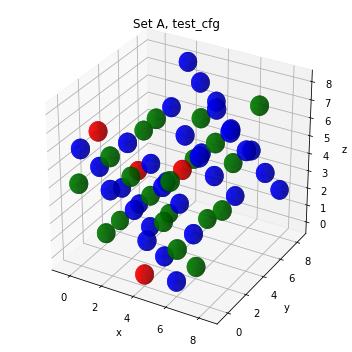

In [6]:
plot_cell_custom_3D(ase_cell_orig, 'Set A, test_cfg')

In [7]:
# Loop over all set A and count symm ops (find test_cfg with more than 1 symm op!)
# Maybe need to tune threshold?? 

import os

setA_data = 'set_A.dat'

with open(setA_data) as f:
    A_data = f.readlines()
    for line in A_data:
        cfg = os.path.join(line.rstrip(), 'POSCAR_orig')
        ase_cell = ase.io.read(cfg, format='vasp')
        spglib_cell = get_spglib_from_ase(ase_cell)

        symm_ops = spg.get_symmetry(spglib_cell, threshold)
        # Combination of rotation and translation to give total symmetry operation
        tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]
        print(len(tot_symm_ops), line)
        

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.41

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.154

1 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.460

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.452

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.458

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.64

16 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.43

1 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.274

2 /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_A.2/con0.181

2 /home/suzannekwallace/Projec

Number of symm ops when de-coloured with Co: 192


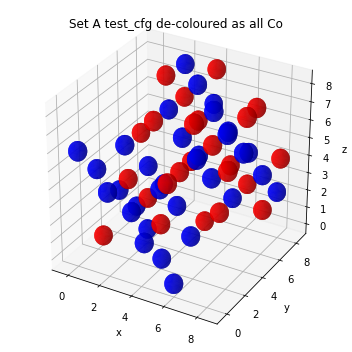

In [8]:
# Checking symmetry operations after de-colouring structure as all Co
all_Co = de_colour(ase_cell_orig, 'Co')
spglib_cell = get_spglib_from_ase(all_Co)
symm_ops = spg.get_symmetry(spglib_cell, threshold)
tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]
print('Number of symm ops when de-coloured with Co: '+str(len(tot_symm_ops)))

plot_cell_custom_3D(all_Co, 'Set A test_cfg de-coloured as all Co')

Number of symm ops when de-coloured with Mn: 192


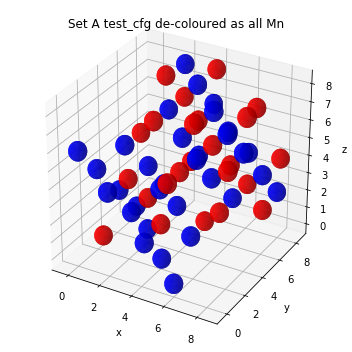

In [9]:
# Checking symmetry operations after de-colouring structure as all Mn
all_Mn = de_colour(ase_cell_orig, 'Mn')
spglib_cell = get_spglib_from_ase(all_Mn)
symm_ops = spg.get_symmetry(spglib_cell, threshold)
tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]
print('Number of symm ops when de-coloured with Mn: '+str(len(tot_symm_ops)))

plot_cell_custom_3D(all_Co, 'Set A test_cfg de-coloured as all Mn')

In [11]:
symm_op_count = len(symm_ops['rotations'])

same_cfg_count = 0
for op_num in range(symm_op_count):
    symm_cfg = all_operations(ase_cell_orig, symm_ops, op_num)
    is_same_as_orig = compare_cfgs(ase_cell, symm_cfg)
    if not is_same_as_orig:
        print('Uh oh, strucuture is not the same as the original!')
    else: 
        same_cfg_count += 1

print('')
print('Number of symmetry operations: '+str(symm_op_count))
print('Number of same structures: '+str(same_cfg_count))

Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the same as the original!
Uh oh, strucuture is not the sa

## Current thoughts on defining parent cfg:

- De-colouring Mn or Co both give same number of symmetry operations for the cfg --> makes sense!
- To undo CASM, using POSCAR_orig (instead of CONTCAR) will most closely represent Javi's setup proceedure
- We then lose information on the symmetry breaking from relaxation, but regain all of the configs originally screened out by CASM that were not taken to the DFT relaxation step
- We are making the assumption that the symmetrically equivalent cubic initial structures would have relaxed to the same final structures, or at least that they are closer in energy to that structure than to any others and hence it is most accurate to assign the energy of the symmetrically equivalent structure that was relaxed
- This step is essentially an attempt to remove (as far as possible) the sample biasing created by CASM (as was not present in the random creation of setC structures)
- If we over-estimate the number of symmetrically equivalent structures for each relaxed config, we just weight that data point a little too highly
- If we under-estimate, we assume the energy distribution is more uniform than in reality
- If we don't so this step at all, we definitely retain a biased sample where the more symmetric alloy atom arrangements are not weighted high enough when computed entropic contributions to the free energy

## Next steps for algorithm:
- Use POSCAR_orig and de-coloured cfg_orig to define parent_cfg
- Use spglib to obtain symmetry operations of parent
- For each cfg in setA data, generate random substitutions respecting number of Co on td and oh sites
- **Note:** Creating all permuations of list of length 16 is prohibitively slow, best option is to randomly shuffle td_atoms and oh_atoms lists 100k times, count degeneracy, compute fraction of degeneracy w.r.t to number of attempts and then compare between configs as essentially this step is just to weight each config w.r.t the others
- For each random cfg, one-at-a-time, apply all symm ops of parent and if any give the same as the orig_cfg, symm_degen_count += 1, and move onto next random structure
- Repeat proceedure for setB data
- Add symm_degen to .info file for setA and setB (to take on to next analysis step!)

### Identifying oh and td sites when creating random cfgs for sets A and B:
The coordinates in POSCAR_orig are always given as: first 8 = td TM, next 16 = oh TM. Therefore can use these each time to define td and oh sites and then use rules to define Co_td and Co_oh such as:

**For set A:**
- if Co_count <= 8, then Co_td = Co_count and Co_oh = 0
- if Co_count > 8, then Co_td = 8 and Co_oh = Co_count - 8

**For set B:**
- if Co_count <=16, then Co_oh = Co_count and Co_td = 0
- if Co_count > 16, then Co_oh = 16 and Co_td = Co_count -16

**General:**
- if Co_count == 0 or Co_count == 24, then assign symm_degen_count = 1 and do not proceed as these are parent cfgs




In [154]:
# Here just for a test_cfg in set A, later loop over whole of set in dir lists: 'set_A.dat' and 'set_B.dat'
'''
data_locs = 'set_A.dat'

with open(data_locs) as f:
    all_set_locs = f.readlines()
    
for loc in all_set_locs:
    inpt_cfg = loc.rstrip()
    print(inpt_cfg)
    
'''

# INPUTS:
threshold = 1e-3 # used by spglib for identifying spacegroup of cfgs
cfg_inpt = '/home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_B.2/con0.503'
struc_type = 'B'
inpt_file = 'setB_all.info'
output_file = 'setB_all+degen.info'



all_set_deg_frac = []
try:
    
    ### Step 0: Read in orig config with ase
    orig_cfg = os.path.join(cfg_inpt, 'POSCAR_orig')
    ase_cell_orig = ase.io.read(orig_cfg, format='vasp')

    ### Step 1: Create parent
    parent_cfg = de_colour(ase_cell_orig, 'Co')

    ### Step 2: Obtain symmetry operations of parent
    spglib_cell = get_spglib_from_ase(parent_cfg)
    symm_ops = spg.get_symmetry(spglib_cell, threshold)
    tot_symm_ops = [(r, t) for r, t in zip(symm_ops['rotations'], symm_ops['translations'])]
    symm_op_count = len(tot_symm_ops)

    ### Step 3a: Generate random substitutions of original config (respecting if cfg is A- or B-type)
    ### Step 3b: For each random cfg (one-at-a-time), apply all symm ops of parent and check for equivalence with orig cfg

    # Assigning count of Co_td and Co_oh based on if structure is set A or set B
    Co_count = ase_cell_orig.get_chemical_symbols().count('Co')
    if (struc_type == 'A'):
        if (Co_count <= 8):
            Co_td = Co_count
            Co_oh = 0
        elif (Co_count > 8):
            Co_td = 8
            Co_oh = Co_count - 8
        else:
            print('Error in checking Co_count')
    elif (struc_type == 'B'):
        if (Co_count <= 16):
            Co_oh = Co_count
            Co_td = 0
        elif (Co_count > 16):
            Co_oh = 16
            Co_td = Co_count - 16
        else:
            print('Error in checking Co_count')
    else:
        print('Error checking if struc is set A or set B')

    # Generating random substitutions of orig cfg and checking for symm degeneracy with orig cfg
    degeneracy_count = 0
    orig_coords = ase_cell_orig.get_scaled_positions()
    orig_cell = ase_cell_orig.get_cell()
    all_atoms = ase_cell_orig.get_atomic_numbers()
    td_atoms = all_atoms[0:8]
    oh_atoms = all_atoms[8:24]
    ox_atoms = all_atoms[24:56]
    # Set attempts to be 100x combination space based on Co_td and Co_oh counts
    combinations = calc_combs(Co_td, Co_oh)
    attempts = int(combinations*100)
    orig_atom_list = atom_nums_with_coords_pdSorted(ase_cell)
    for i in range(attempts):
        counter = i
        # Randomly shuffle lists of td and oh atoms
        td_shuf = np.random.choice(td_atoms, size=td_atoms.shape)
        oh_shuf = np.random.choice(oh_atoms, size=oh_atoms.shape)
        all_atoms_shuf = np.concatenate((td_shuf, oh_shuf, ox_atoms), axis=0)
        # Create rand_cfg ase Atoms object with orig cfg coords and shuffled td and oh atomic numbers
        rand_cfg = Atoms(cell=orig_cell, scaled_positions=orig_coords, pbc=True)
        rand_cfg.set_atomic_numbers(all_atoms_shuf)
        # Checking timing for comparing cfgs
        #t0 = time.time()
        isEquiv = check_for_equiv(symm_ops, symm_op_count, ase_cell_orig, rand_cfg)
        #print('It took {0} s to compare cfgs'.format((time.time()-t0)))
        if isEquiv:
            degeneracy_count += 1

    degeneracy_frac = float(degeneracy_count)/float(counter)

except:
    print('Error in processing config from: '+str(cfg_inpt))
else: # If no errors in code above, add data to final degeneracy fractions list
    all_set_deg_frac.append(degeneracy_frac)

    
print('Degeneracy fraction: '+str(degeneracy_frac)+' of '+str(counter)+' attempts')


'''
    ### Step 4: Add all_set_deg_frac list as extra column in .info files for setA or setB
    with open(inpt_file, 'r') as f_in:
        with open(output_file, 'w') as f_out:
            lines = f_in.readlines()
            f_out.write(lines[0].rstrip()+', symm_degen_frac\n')
            for line, symm_degen in zip(range(1, len(lines)), all_set_deg_frac):
                f_out.write(lines[line].rstrip()+' '+str(symm_degen)+'\n')
                
'''             

It took 0.17833757400512695 s to compare cfgs
It took 0.16578936576843262 s to compare cfgs
It took 0.16474413871765137 s to compare cfgs
It took 0.16107559204101562 s to compare cfgs
It took 0.16496944427490234 s to compare cfgs
It took 0.1647815704345703 s to compare cfgs
It took 0.16928315162658691 s to compare cfgs
It took 0.16272306442260742 s to compare cfgs
It took 0.16637134552001953 s to compare cfgs
It took 0.16299009323120117 s to compare cfgs
It took 0.16828632354736328 s to compare cfgs
It took 0.16830825805664062 s to compare cfgs
It took 0.17138028144836426 s to compare cfgs
It took 0.1711587905883789 s to compare cfgs
It took 0.1666877269744873 s to compare cfgs
Error in processing config from: /home/suzannekwallace/Projects/Co_xMn_{3-x}O_4/comparisonStudy_NNandMTP/oneElongAB+B1/block_B.2/con0.503
Degeneracy fraction: 0.0 of 15 attempts


"\n    ### Step 4: Add all_set_deg_frac list as extra column in .info files for setA or setB\n    with open(inpt_file, 'r') as f_in:\n        with open(output_file, 'w') as f_out:\n            lines = f_in.readlines()\n            f_out.write(lines[0].rstrip()+', symm_degen_frac\n')\n            for line, symm_degen in zip(range(1, len(lines)), all_set_deg_frac):\n                f_out.write(lines[line].rstrip()+' '+str(symm_degen)+'\n')\n                \n"

In [130]:
print('Degeneracy fraction: '+str(degeneracy_frac)+' of '+str(counter)+' attempts')
    


Degeneracy fraction: 0.0 of 30052 attempts


In [158]:
print(atom_nums_with_coords_flat(ase_cell_orig))




['251.00570176955511161.00570176955511161.0057017695551116', '257.039911244406687.039911244406687.03991124440668', '255.0285188404448891.00570176955511165.028518840444889', '253.0171231055933217.039911244406683.017123105593321', '251.00570176955511165.0285188404448895.028518840444889', '257.039911244406683.0171231055933213.017123105593321', '255.0285188404448895.0285188404448891.0057017695551116', '253.0171231055933213.0171231055933217.03991124440668', '274.022839815878664-2.8874983921375447e-05-2.8874983921375447e-05', '27-2.8874983921375447e-054.022839815878664-2.8874983921375447e-05', '27-2.8874983921375447e-05-2.8874983921375447e-054.022839815878664', '254.0228047771709874.0228047771709874.022804777170987', '252.01143510210682756.034195177771537-2.8874983921375447e-05', '256.0341951777715372.0114351021068275-2.8874983921375447e-05', '256.034195177771537-2.8874983921375447e-052.0114351021068275', '252.0114351021068275-2.8874983921375447e-056.034195177771537', '25-2.8874983921375447e

In [174]:
transformed = all_operations(rand_cfg, symm_ops, 3)

ase_cell = ase_cell_orig

atoms = ase_cell.get_atomic_numbers()
positions = ase_cell.get_scaled_positions()
list_of_strings = []
for atom, pos in zip(atoms, positions):
    print(np.round(pos[0], 3))
    atomAndCoords = str(atom)+str(pos[0])+str(pos[1])+str(pos[2])
    list_of_strings.append(atomAndCoords) 

print('')
ase_cell = transformed
    
atoms = ase_cell.get_atomic_numbers()
positions = ase_cell.get_scaled_positions()
list_of_strings = []
for atom, pos in zip(atoms, positions):
    print(np.round(pos[0],3))
    atomAndCoords = str(atom)+str(pos[0])+str(pos[1])+str(pos[2])
    list_of_strings.append(atomAndCoords) 


0.125
0.875
0.625
0.375
0.125
0.875
0.625
0.375
0.5
1.0
1.0
0.5
0.25
0.75
0.75
0.25
1.0
1.0
0.25
0.75
0.75
0.25
0.5
0.5
0.263
0.737
0.487
0.513
0.987
0.013
0.763
0.237
0.013
0.987
0.513
0.487
0.237
0.763
0.263
0.737
0.487
0.513
0.987
0.013
0.013
0.987
0.513
0.487
0.763
0.237
0.263
0.737
0.737
0.263
0.763
0.237

0.375
0.125
0.875
0.625
0.375
0.125
0.875
0.625
0.75
0.25
0.25
0.75
0.5
1.0
1.0
0.5
0.25
0.25
0.5
0.0
0.0
0.5
0.75
0.75
0.513
0.987
0.737
0.763
0.237
0.263
0.013
0.487
0.263
0.237
0.763
0.737
0.487
0.013
0.513
0.987
0.737
0.763
0.237
0.263
0.263
0.237
0.763
0.737
0.013
0.487
0.513
0.987
0.987
0.513
0.013
0.487
